# **CDS Project: Part 2**

*Institute of Software Security (E22)*  
*Hamburg University of Technology*  

## Learning objectives
---

- Identify and extract vulnerable code from software reposiroties
- Identify and extract non-vulnerabile code from software reposiroties.
- Select and apply pre-proceesing techniques.
- Create a dataset of security vulnerabilities.

## Materials
---

- Lecture Slides 3, 5 and 6.
- PyTorch Documentation: [Datasets and Data Loaders](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) 
- [ProjectKB GitHub repo](https://github.com/SAP/project-kb).
- PyDriller Documentation: [PyDriller](https://pydriller.readthedocs.io/en/latest/)

## Project Description
---

In this project, you will create your own dataset of security vulnerabilities. This dataset shoul be generated using the information contained in ProjectKB. ProjectKB is a repository created to enable the creation, management and aggregation of a distributed and collaborative knowledge base of vulnerabilities affecting open-source software written in Java programming language. This repository contains a list of CVEs and the corresponding commits that fix it. Usually the vulnerabilities are contained in a method. Your task is to use this repository to extract the vulnerable and fixed version of the methods.

###*Task 1*

- Download the ProjectKB repository (i.e., create a local copy by cloning it).
- Locate the folder containing the CVEs and their corresponding fixing commits.

###*Task 2*

- Write a script that extracts (i) the repository URLs and (ii) corresponding fixing commit ID (hash) contained on each CVE.

In [3]:
# TODO: From ProjectKB extract the commit IDs of the fixing commits 

# TODO: Extract the URLs of the respositories that contain the fix for different CVEs 

In [1]:
import yaml
import os
import glob
import csv
import zipfile

ZIP_FILE = "project-kb.zip"
EXTRACTED_FOLDER = "project-kb"

if not os.path.exists(EXTRACTED_FOLDER):
    with zipfile.ZipFile(ZIP_FILE, 'r') as zip_ref:
        zip_ref.extractall(EXTRACTED_FOLDER)
    print(f"✅ Extracted {ZIP_FILE} to {EXTRACTED_FOLDER}")
else:
    print(f"✅ Folder {EXTRACTED_FOLDER} already exists")
STATEMENTS_FOLDER = os.path.join(EXTRACTED_FOLDER, "statements")
OUTPUT_CSV = "cve_commits.csv"
def extract_repo_and_commits(yaml_file):
    with open(yaml_file, 'r', encoding='utf-8') as f:
        data = yaml.safe_load(f)

    repo_url = None
    commit_hashes = []

     fixes = data.get('fixes', [])
    for fix in fixes:
        commits = fix.get('commits', [])
        for commit_entry in commits:
            commit_id = commit_entry.get('id')
            if commit_id:
                commit_hashes.append(commit_id)
            if not repo_url and commit_entry.get('repository'):
                repo_url = commit_entry['repository']


    if not repo_url:
        repo_url = data.get('repo')

 
    return repo_url, list(set(commit_hashes))


def main():
    results = []

   
    yaml_files = glob.glob(os.path.join(STATEMENTS_FOLDER, "**", "*.yaml"), recursive=True)
    yaml_files += glob.glob(os.path.join(STATEMENTS_FOLDER, "**", "*.yml"), recursive=True)

    print(f"✅ Found {len(yaml_files)} YAML files")

    for yf in yaml_files:
        repo_url, commits = extract_repo_and_commits(yf)
        for commit in commits:
            results.append({
                "file": os.path.relpath(yf, STATEMENTS_FOLDER),
                "repo_url": repo_url,
                "commit_hash": commit
            })

    with open(OUTPUT_CSV, 'w', newline='', encoding='utf-8') as csvfile:
        fieldnames = ['file', 'repo_url', 'commit_hash']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        for row in results:
            writer.writerow(row)

    print(f"✅ Done! Extracted info saved to {OUTPUT_CSV}")
    print(f"✅ Total rows: {len(results)}")

if __name__ == "__main__":
    main()


✅ Folder project-kb already exists
✅ Found 1297 YAML files
✅ Done! Extracted info saved to cve_commits.csv
✅ Total rows: 1885


###*Task 3*

- Using the URL, identify and extract the method where the "fix" is introduced. 
- Locate the previous version of the file and extract the same function (i.e., the "vulnerable" version of the same function). 

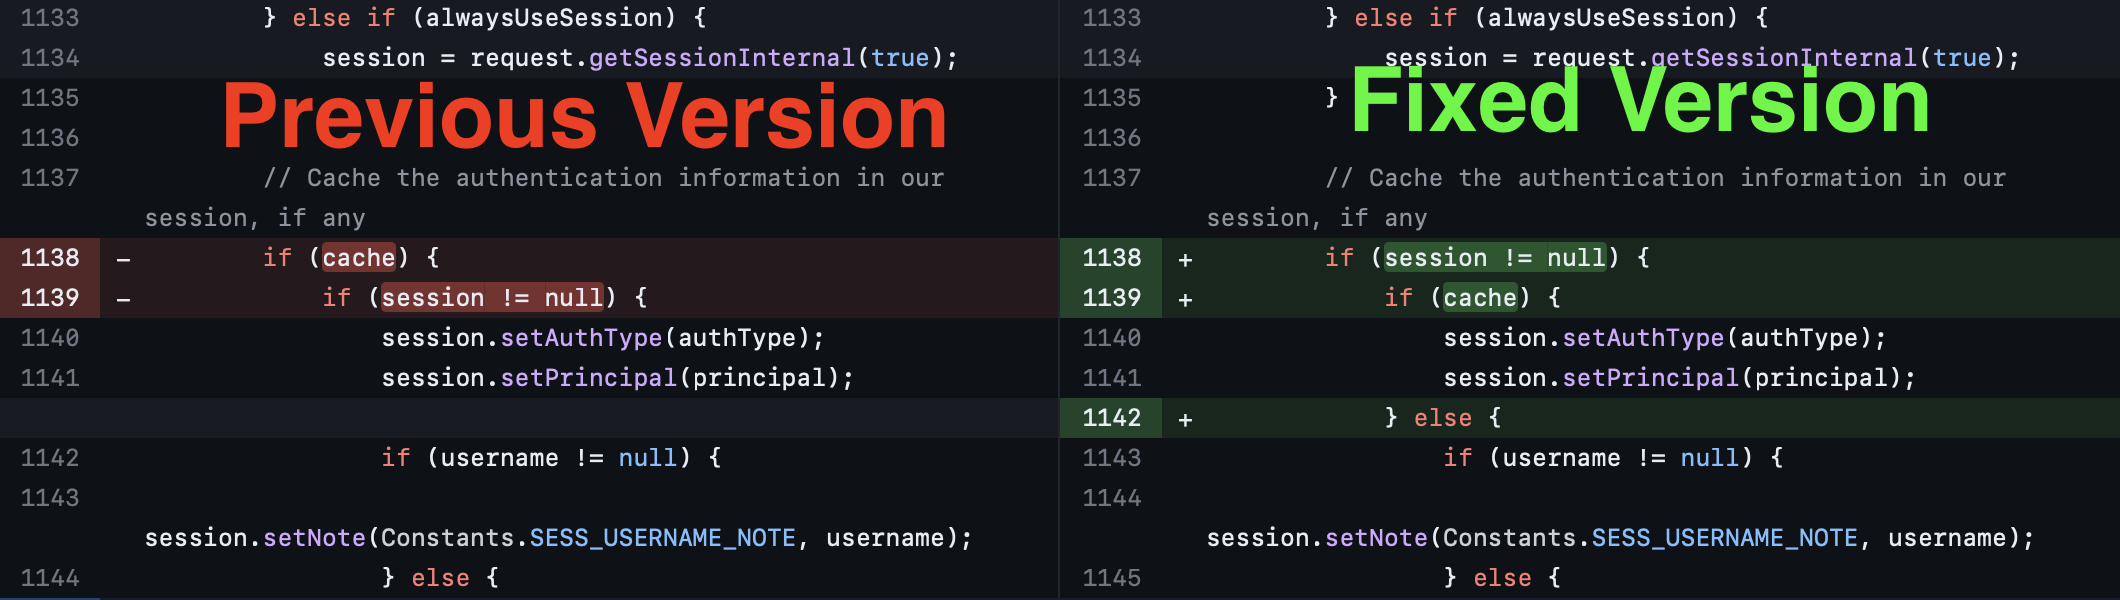

In [ ]:
# TODO: Extract the method where the fix is introduced

# TOD: Extract the vulnerable version of the same method from the previous version of the file.

In [2]:
!pip install GitPython

In [4]:
import os
import subprocess
from git import Repo

# === INPUT ===
repo_url = "https://github.com/igniterealtime/Openfire.git"
commit_hash = "c9cd1e521673ef0cccb8795b78d3cbaefb8a576a"

# === LOCAL FOLDER ===
repo_name = repo_url.split("/")[-1].replace(".git", "")
clone_dir = f"./repos/{repo_name}"
if not os.path.exists(clone_dir):
    print(f"Cloning {repo_url} ...")
    Repo.clone_from(repo_url, clone_dir)
else:
    print(f"Repo {repo_name} already cloned.")

repo = Repo(clone_dir)
commit = repo.commit(commit_hash)
parent = commit.parents[0]
print(f"Parent: {parent}")

diff_files = commit.diff(parent)
for diff in diff_files:
    changed_file = diff.a_path
    print(f"Changed file: {changed_file}")

   
    os.chdir(clone_dir)  # Run git commands inside repo
    cmd = ["git", "diff", "--function-context", f"{parent.hexsha}", f"{commit.hexsha}", "--", changed_file]
    print("\n=== DIFF ===")
    subprocess.run(cmd)

    parent_file = repo.git.show(f"{parent.hexsha}:{changed_file}")
    fixed_file = repo.git.show(f"{commit.hexsha}:{changed_file}")


    with open("parent_version.java", "w") as f:
        f.write(parent_file)

    with open("fixed_version.java", "w") as f:
        f.write(fixed_file)

    print("✅ Saved parent_version.java and fixed_version.java")

    break 

Cloning https://github.com/igniterealtime/Openfire.git ...
Parent: 9d4ff701f3e7871d0a1addb146fe7c8da1825a40
Changed file: documentation/dist/changelog.html

=== DIFF ===
✅ Saved parent_version.java and fixed_version.java


In [7]:
import os
print("Current working directory:", os.getcwd())

Current working directory: C:\Users\amrit\Downloads\Cybersecurity\Lab_2\repos\Openfire


In [8]:
import os
import csv
import subprocess
from git import Repo, GitCommandError

CSV_FILE = r"C:\Users\amrit\Downloads\Cybersecurity\Lab_2\cve_commits.csv"
REPOS_DIR = "./repos"
OUTPUT_DIR = "./extracted_methods"


os.makedirs(REPOS_DIR, exist_ok=True)
os.makedirs(OUTPUT_DIR, exist_ok=True)

rows = []
with open(CSV_FILE, newline='') as f:
    reader = csv.DictReader(f)
    for row in reader:
        rows.append(row)

print(f"✅ Loaded {len(rows)} rows")

seen_repos = {}

for i, row in enumerate(rows):
    repo_url = row['repo_url']
    commit_hash = row['commit_hash']

    if not repo_url or not commit_hash:
        print(f"[{i+1}] Skipping empty repo or commit")
        continue
    if not (".git" in repo_url or "github.com" in repo_url):
        print(f"[{i+1}] Skipping non-Git repo: {repo_url}")
        continue

    repo_name = repo_url.split("/")[-1].replace(".git", "")
    clone_dir = os.path.join(REPOS_DIR, repo_name)

    try:
        
        if repo_url not in seen_repos:
            if not os.path.exists(clone_dir):
                print(f"[{i+1}] ⏳ Cloning {repo_url} ...")
                Repo.clone_from(repo_url, clone_dir)
            else:
                print(f"[{i+1}] ✅ Repo {repo_name} already cloned.")
            seen_repos[repo_url] = Repo(clone_dir)

        repo = seen_repos[repo_url]

        
        commit = repo.commit(commit_hash)
        parent = commit.parents[0]
        print(f"[{i+1}] Parent: {parent}")

        
        diff_files = commit.diff(parent)
        if not diff_files:
            print(f"[{i+1}] No changed files")
            continue

        for diff in diff_files:
            changed_file = diff.a_path
            print(f"[{i+1}] Changed file: {changed_file}")

            
            parent_file = repo.git.show(f"{parent.hexsha}:{changed_file}")
            fixed_file = repo.git.show(f"{commit.hexsha}:{changed_file}")

           
            base_name = f"{repo_name}_{commit_hash}_{os.path.basename(changed_file).replace('/', '_')}"
            parent_out = os.path.join(OUTPUT_DIR, f"{base_name}_parent.java")
            fixed_out = os.path.join(OUTPUT_DIR, f"{base_name}_fixed.java")

            with open(parent_out, "w", encoding='utf-8') as f:
                f.write(parent_file)

            with open(fixed_out, "w", encoding='utf-8') as f:
                f.write(fixed_file)

            print(f"[{i+1}] ✅ Saved {parent_out} & {fixed_out}")
            break  # One file per commit for now

    except GitCommandError as ge:
        print(f"[{i+1}] ❌ Git ERROR: {ge}")
    except Exception as e:
        print(f"[{i+1}] ❌ Other ERROR: {e}")

print("\n✅ ALL DONE!")



✅ Loaded 1885 rows
[1] ⏳ Cloning https://github.com/igniterealtime/Openfire ...
[1] Parent: 9d4ff701f3e7871d0a1addb146fe7c8da1825a40
[1] Changed file: documentation/dist/changelog.html
[1] ✅ Saved ./extracted_methods\Openfire_c9cd1e521673ef0cccb8795b78d3cbaefb8a576a_changelog.html_parent.java & ./extracted_methods\Openfire_c9cd1e521673ef0cccb8795b78d3cbaefb8a576a_changelog.html_fixed.java
[2] ⏳ Cloning https://github.com/apache/struts ...
[2] Parent: e40a8e540b6183ed59c982924f42d97c75684e68
[2] Changed file: core/src/main/java/org/apache/struts2/dispatcher/DefaultStaticContentLoader.java
[2] ✅ Saved ./extracted_methods\struts_04fcefa44bae1263c7cad6986a9dafed67f0164_DefaultStaticContentLoader.java_parent.java & ./extracted_methods\struts_04fcefa44bae1263c7cad6986a9dafed67f0164_DefaultStaticContentLoader.java_fixed.java
[3] Parent: 9ee344fecae3dbd6aa38eb7dadd3342e3de88057
[3] Changed file: core/src/main/java/org/apache/struts2/dispatcher/FilterDispatcher.java
[3] ✅ Saved ./extracted_meth

### *Task 4*
-  Create a labeled dataset using the non-vulnerable and  vulnerable functions extracted in **Step 3**.
- Find a suitable file format for the dataset (CSV, JSON, HDF5, etc.).
- The dataset should contain the following structure:
  - function code
  - boolean label: vulnerable / non-vulnerable

In [5]:
import os
import csv

# === CONFIG ===
EXTRACTED_DIR = "C:/Users/amrit/Downloads/Cybersecurity/Lab_2/repos/Openfire/extracted_methods"
OUTPUT_CSV = "labeled_dataset.csv"

all_files = os.listdir(EXTRACTED_DIR)
pairs = {}

for f in all_files:
    if f.endswith("_parent.java"):
        base = f.replace("_parent.java", "")
        pairs.setdefault(base, {})['parent'] = f
    elif f.endswith("_fixed.java"):
        base = f.replace("_fixed.java", "")
        pairs.setdefault(base, {})['fixed'] = f

print(f"✅ Found {len(pairs)} method pairs")


with open(OUTPUT_CSV, "w", newline='', encoding="utf-8") as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=["function_code", "label"])
    writer.writeheader()

    for base, files in pairs.items():

        if 'parent' in files:
            with open(os.path.join(EXTRACTED_DIR, files['parent']), encoding='utf-8') as f:
                code = f.read()
                writer.writerow({"function_code": code.strip(), "label": 1})

        
        if 'fixed' in files:
            with open(os.path.join(EXTRACTED_DIR, files['fixed']), encoding='utf-8') as f:
                code = f.read()
                writer.writerow({"function_code": code.strip(), "label": 0})

print(f"✅ Saved labeled dataset to {OUTPUT_CSV}")


✅ Found 1592 method pairs
✅ Saved labeled dataset to labeled_dataset.csv


In [6]:
import os
print("Current working directory:", os.getcwd())

Current working directory: C:\Users\amrit\Downloads\Cybersecurity\Lab_2
